In [2]:
#from http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Summary of Zheng 2016 heat shock response model

The central feature of this model is that the key transcription factor involved in the induction of the heat shock response in yeast, heat shock factor 1 (HSF1), is constitutively bound and repressed by chaperones; after heat shock there is an increase in the number of client proteins (both unfolded proteins and proteins that assemble in response to stress) which titrates away the HSP70, allowing HSF1 to upregulate HSP70. When all the client protein is bound by HSP70, the remaining free HSP70 can then bind to HSF1, negatively regulating its own transcription.

A schematic of the model can be found in Figure 1B of the paper, and the equations are in the supplementary information (I'll reproduce them here later). All binding relationships here are linear, except for the binding of transcription factor HSF1 to DNA, which is cooperative (Hill coefficient = 3).

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [8]:
def deriv(z, t):
    """Function used with odeint to simulate the heat shock response including HSF1 activity, HSP70, and unfolded proteins"""
    
    HSP = z[0]
    HSF1 = z[1]
    HSP_HSF1 = z[2]
    HSP_UP = z[3]
    UP = z[4]
    YFP = z[5]
        
    dHSPdt = k2*HSP_HSF1 - k1*HSP*HSF1 + (k4 + k5)*HSP_UP - k3*HSP*UP + \
    beta*(HSF1**n / (Kd**n + HSF1**n))
    dHSF1dt = k2*HSP_HSF1 - k1*HSP*HSF1
    dHSP_HSF1dt = -k2*HSP_HSF1 + k1*HSP*HSF1
    dHSP_UPdt = -(k4 + k5)*HSP_UP + k3*HSP*UP
    dUPdt = k4*HSP_UP - k3*HSP*UP
    dYFPdt = beta*(HSF1**n / (Kd**n + HSF1**n)) - kdil*YFP
    
    
    return(np.array([dHSPdt, dHSF1dt, dHSP_HSF1dt, dHSP_UPdt, dUPdt, dYFPdt]))


def plot_species_vs_time(data, time, colors, temps, species_name, index):
    """For a matrix of data where each column is the amount of a species """
    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(111)
    if type(index) == int:
        for i in range(len(data)):
            ax.plot(time, data[i][:,index], color = colors[i], label = temps[i])
    elif type(index) == list:
        for i in range(len(data)):
            for j in range(len(index)):
                if j == 0:
                    to_plot = np.asarray(data[i][:,index[j]])
                else:
                    to_plot += np.asarray(data[i][:,index[j]])
            ax.plot(time, to_plot, color = colors[i], label = temps[i])
    else:
        print("Invalid index type; must be int or list of integers")
        return()
    ax.legend(title="Temperature")
    title = "{} vs. time".format(species_name)
    plt.title(title)
    plt.show()
    

In [20]:
# Parameters
k1 = 166.8 # per min per au, client:hsp70 off rate
k3 = k1
k2 = 2.783 # per min, HSP70:HSF1 off rate
k4 = 0.0464 # per min HSP70:UP off rate
k5 = 4.64e-7 # degradation rate of HSP70:UP
beta = 1.778 # Transcription activation rate
Kd = 0.0022 # Dissociation constant of HSF1-DNA interaction
#kdil = 2.78e-3 # Dilution rate of YFP; assuming 50% growth rate
kdil = 0 # No growth for now
n = 3 # Hill coefficient


# Initial values
HSP_0 = 1 # Free HSP70
HSF1_0 = 0 # Free HSF1
HSP_HSF1_0 = 1/500.
HSP_UP_0 = 0
YFP_0 = 3 # 

In [145]:
T = [37, 39, 40, 42, 45]
z = []

for t in T:
    UP_0 = 0.0024*np.exp(0.215*t) # generates initial value of UP; empirical
    time = np.arange(0, 200, 1)
    zinit = np.array([HSP_0, HSF1_0, HSP_HSF1_0, HSP_UP_0, UP_0, YFP_0])
    z.append(odeint(deriv, zinit, time))


## Plots
names = ['37', '39', '40', '42', '45']
colors = ['royalblue', 'firebrick', 'gold', 'darkgreen', 'k']

## Initial explorations of the system

Some plots of the species vs time, phase plane analysis of a few pertinant variables, plots of the time it takes to clear client protein as a function of time.

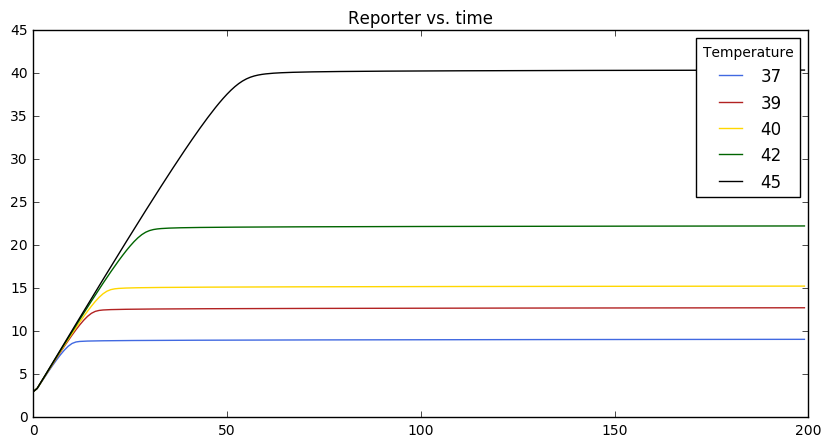

In [123]:
plot_species_vs_time(z, time, colors, names, "Reporter", 5)

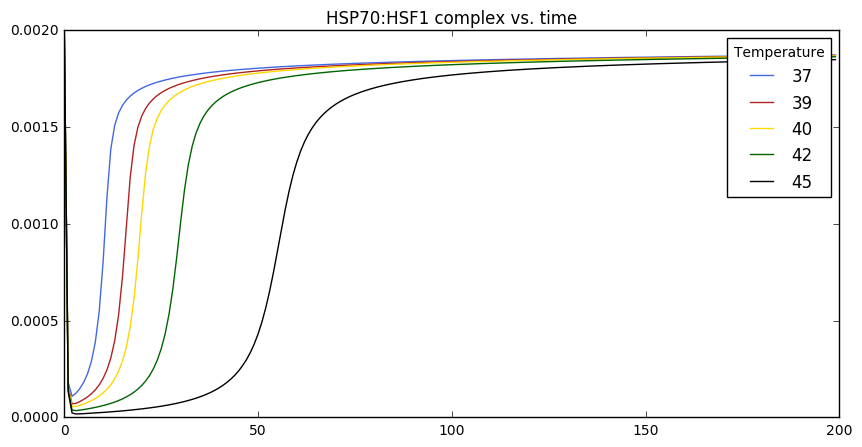

In [124]:
plot_species_vs_time(z, time, colors, names, "HSP70:HSF1 complex", [2])

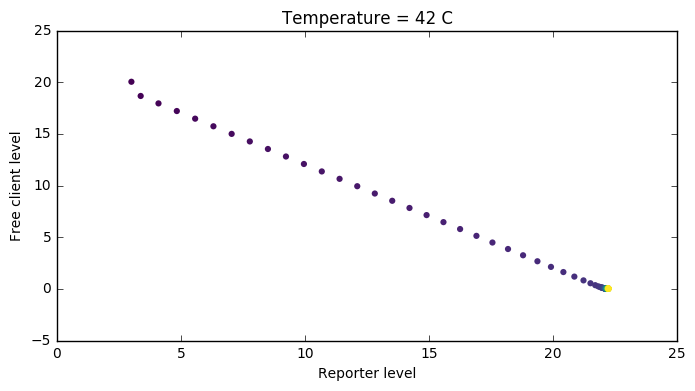

In [151]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(111)
ax.scatter(z[3][:,5], z[3][:,4], c = time, cmap = "viridis", linewidths = 0)
ax.set_ylabel("Free client level")
ax.set_xlabel("Reporter level")
ax.set_title("Temperature = 42 C")
ax.set_ylim(-5, 25)
plt.show()

There is a linear relationship between the reporter level and the free client level when there is no degradation or dilution of the reporter. Color of the dots in this plot indicates time from light -> dark. The same plot in log-log is shown below:

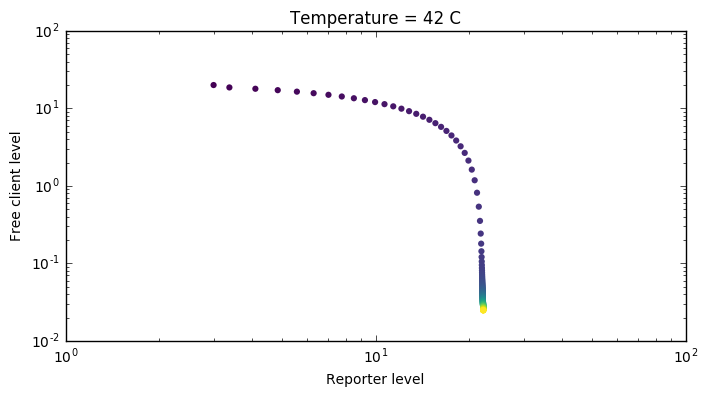

In [152]:
f = plt.figure(figsize = (8,4))
ax = f.add_subplot(111)
ax.scatter(z[3][:,5], z[3][:,4], c = time, cmap = "viridis", linewidths = 0)
ax.set_ylabel("Free client level")
ax.set_xlabel("Reporter level")
ax.set_title("Temperature = 42 C")
#ax.set_ylim(-5, 25)
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

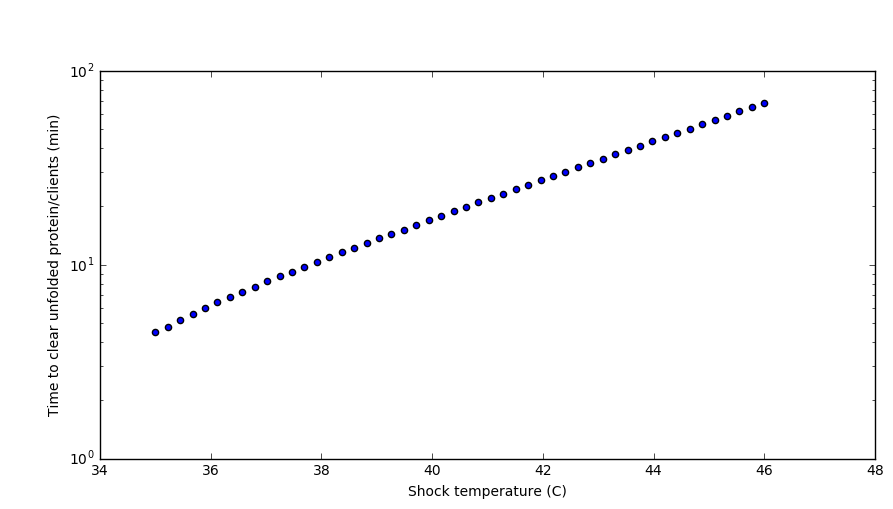

In [134]:
T = np.linspace(35, 46)
times = []

for t in T:
    UP_0 = 0.0024*np.exp(0.215*t) # generates initial value of UP; empirical
    time = np.arange(0, 200, 0.1)
    zinit = np.array([HSP_0, HSF1_0, HSP_HSF1_0, HSP_UP_0, UP_0, YFP_0])
    x = odeint(deriv, zinit, time) # run the simulation
    times.append(time[np.min(np.where(x[:,4] < 1))])
    
    
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.scatter(T, times)
ax.set_xlabel("Shock temperature (C)")
ax.set_ylabel("Time to clear unfolded protein/clients (min)")
ax.set_yscale("log")
ax.annotate("[P](0) = 0.0024*exp(0.215*temp)", (35, 500))
plt.show()

The equation annotated on the plot is the function used to generate the starting amount of client protein P; no additional P is generated in the simulation.

## Finding fixed points

Using a hack-y way of finding fixed points for now, which is to evaluate the total change in the system from one timepoint to the next, and if it is very small (close to zero), call that a fixed point of the system.

In [139]:
cutoff = 1e-3
p_is = []
yfp_fs = []
fps = []

for t in T:
    UP_0 = 0.0024*np.exp(0.215*t) # generates initial value of UP; empirical
    p_is.append(UP_0)
    time = np.arange(0, 200, 0.1)
    zinit = np.array([HSP_0, HSF1_0, HSP_HSF1_0, HSP_UP_0, UP_0, YFP_0])
    x = odeint(deriv, zinit, time) # run the simulation
    for row in range(1, len(x)):
        if sum(x[row] - x[row - 1] < cutoff) == len(x[row]):
            fps.append(time[row])
            yfp_fs.append(x[row][-1])
            break

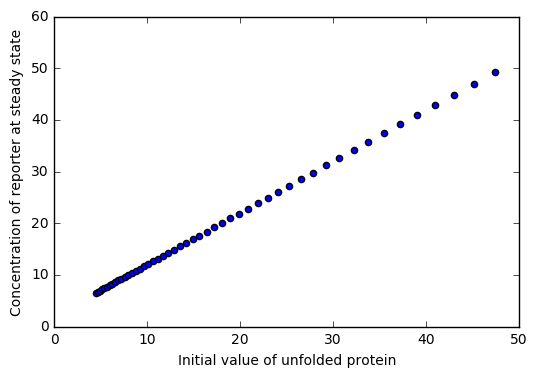

In [142]:
plt.scatter(p_is, yfp_fs)
plt.xlabel("Initial value of unfolded protein")
plt.ylabel("Concentration of reporter at steady state")
plt.show()